In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

## Clustering
Example used:
https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

In [176]:
## import network
G = pickle.load(open('data/cleaned_network.p', 'rb'))

pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])

df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

berth_nodes = df_nodes.loc[df_nodes.n.str.contains('Berth')].index

In [46]:
len(df_links)

3320

In [3]:
berth_nodes_2 = df_nodes.loc[df_nodes.n.str.contains('Berth')].loc[:, ['X', 'Y']].to_numpy()

In [113]:
number_of_clusters = []
cor_harbour_clusters = []
distortions = []

for cn in range(700, 851, 10):
    print(cn)
    #reset df nodes each time
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

    #determine amount of clusters and append value
    number_of_clusters.append(cn)
    #define Kmeans with cluster size based on loop
    km = KMeans(n_clusters=cn, init='random', n_init=100, max_iter=300,
                tol=1e-04, random_state=0)

    # print('avg group size', i, 'results in', round(len(G.nodes)/i), 'clusters')

    #establish input for kmeans
    X = df_nodes.X.to_numpy()
    Y = df_nodes.Y.to_numpy()
    arr = np.vstack((X, Y)).T

    y_km = km.fit_predict(arr)
    df_nodes['cluster'] = y_km

    #now extract and append data for harbour clusters
    df_ch = pd.DataFrame(km.cluster_centers_)
    harbour_clusters = list(df_nodes.loc[df_nodes.index.str.contains('Berth')].cluster.unique())
    resulting_harbour_nodes = df_ch.loc[df_ch.index.isin(harbour_clusters)]
    resulting_harbour_nodes = resulting_harbour_nodes.to_numpy()
    cor_harbour_clusters.append(len(resulting_harbour_nodes))

    #append distortion
    distortions.append(km.inertia_)

700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850


In [9]:
#store data (running takes quite a while)
# pickle.dump( number_of_clusters, open( "data/Clustering_files/number_of_clusters.p", "wb" ) )
# pickle.dump( cor_harbour_clusters, open( "data/Clustering_files/cor_harbour_clusters.p", "wb" ) )
# pickle.dump( distortions, open( "data/Clustering_files/distortions", "wb" ) )

number_of_clusters = pickle.load(  open( "data/Clustering_files/number_of_clusters.p", "rb" ) )
cor_harbour_clusters = pickle.load( open( "data/Clustering_files/cor_harbour_clusters.p", "rb" ) )
distortions = pickle.load( open( "data/Clustering_files/distortions", "rb" ) )


In [114]:
df_plot = pd.DataFrame(list(zip(number_of_clusters,cor_harbour_clusters,distortions)), columns=['Number of clusters', 'Number of harbour nodes', 'Distortion'])
# df_plot.set_index('Number of clusters', inplace=True)

In [115]:
df_plot

,Number of clusters,Number of harbour nodes,Distortion
0,700,136,0.322786
1,710,136,0.323751
2,720,136,0.311160
3,730,131,0.300805
4,740,131,0.290940
5,750,132,0.286357
6,760,132,0.272241
7,770,132,0.267557
8,780,133,0.264185
9,790,135,0.257250


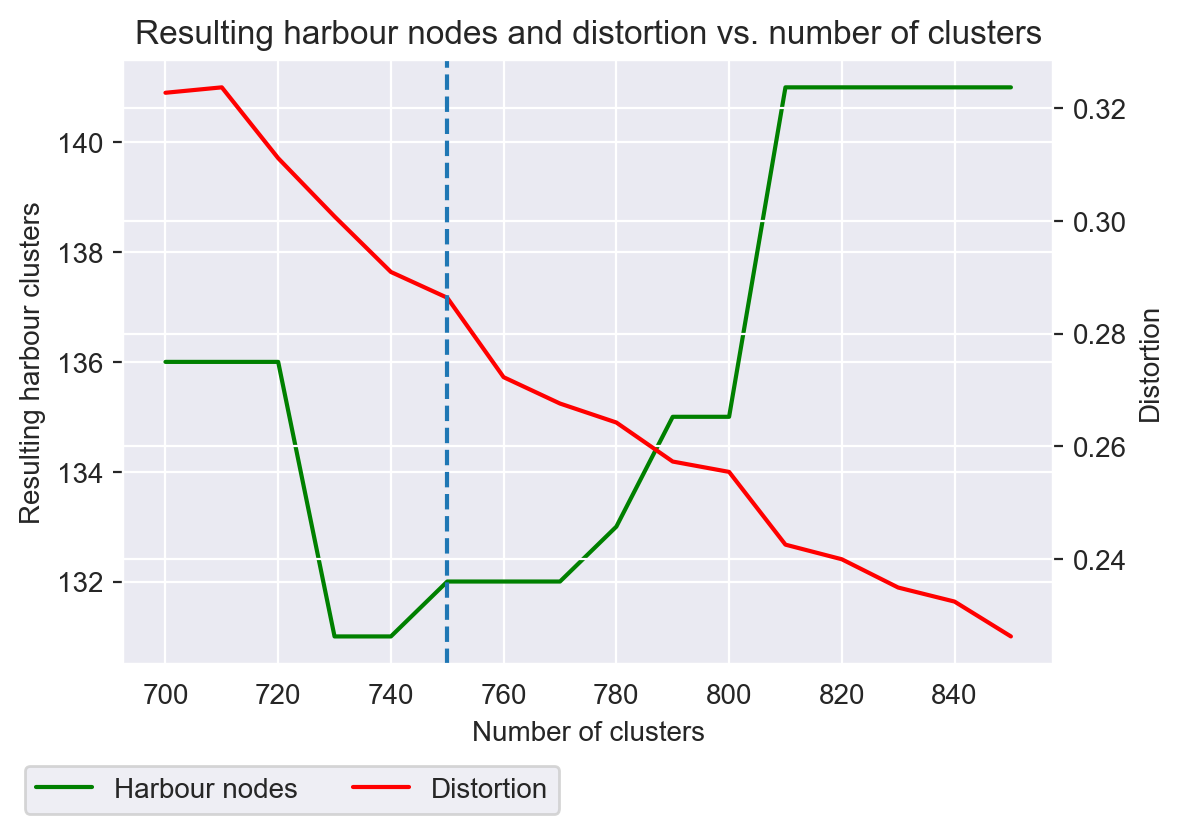

In [116]:
#setup figure and axis
fig, ax = plt.subplots(dpi=200)
ax2 = ax.twinx()
#Plotting
ax.plot(df_plot['Number of clusters'], df_plot['Number of harbour nodes'], color='g', label='Harbour nodes')
ax2.plot(df_plot['Number of clusters'], df_plot['Distortion'], color='r', label='Distortion')
# sns.lineplot(data=df_plot['Distortion'], color='r', ax=ax2, label='Distortion')
#Names and labels
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Resulting harbour clusters')
ax2.set_ylabel('Distortion')
ax.set_title("Resulting harbour nodes and distortion vs. number of clusters")
plt.axvline(x=750,linestyle="--")
fig.legend(bbox_to_anchor=(0.5,-0.08), loc="lower right",
                bbox_transform=fig.transFigure, ncol=3)
plt.show()

In [139]:
len(G.nodes)/3

1085.3333333333333

## Clustering the network
Proceed with value of 730 for the number of clusters, as this seems to provide the best trade-off

In [120]:
clusters = 730
km = KMeans(
    n_clusters=clusters, init='random',
    n_init=100, max_iter=300,
    tol=1e-04, random_state=0
)
X = df_nodes.X.to_numpy()
Y = df_nodes.Y.to_numpy()
arr = np.vstack((X,Y)).T
y_km = km.fit_predict(arr)
y_km

array([590, 661,   4, ..., 116, 623, 312])

In [145]:
len(G.nodes)/730

4.46027397260274

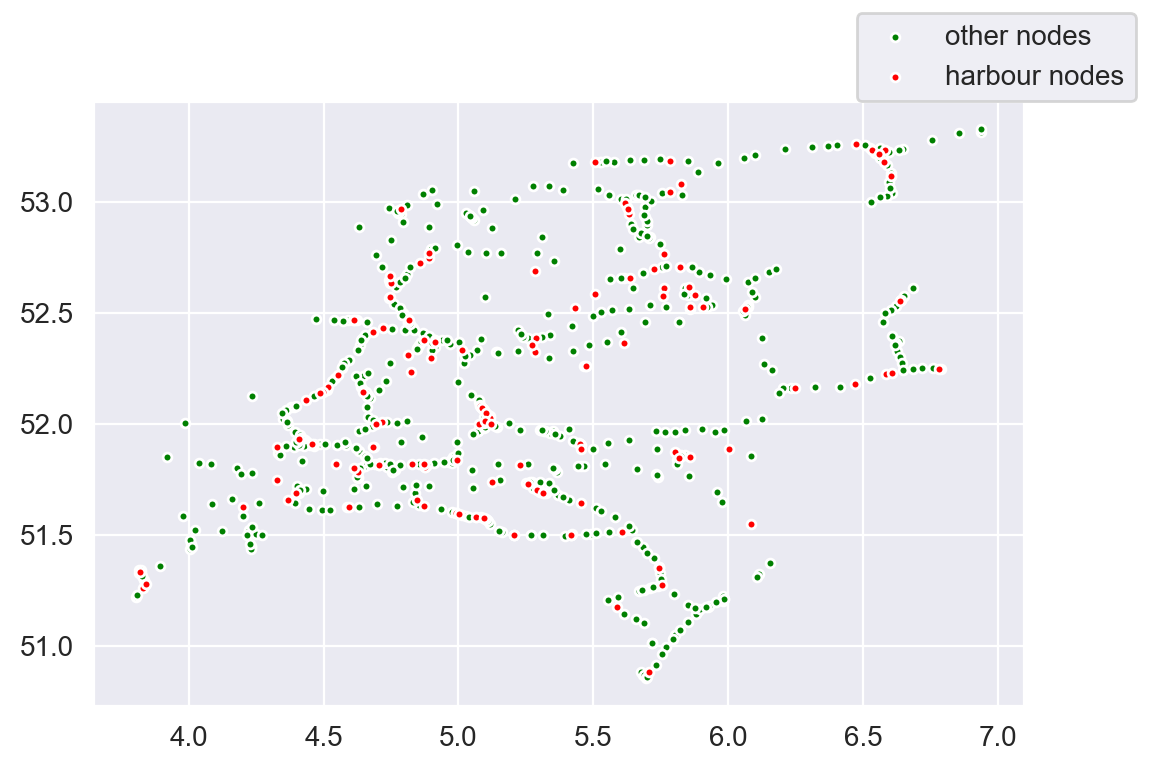

In [146]:
#harbour nodes first
df_ch = pd.DataFrame(km.cluster_centers_)
harbour_clusters = list(df_nodes.loc[df_nodes.index.str.contains('Berth')].cluster.unique())
other_nodes = df_ch.loc[~df_ch.index.isin(harbour_clusters)]
resulting_harbour_nodes = df_ch.loc[df_ch.index.isin(harbour_clusters)]
resulting_harbour_nodes = resulting_harbour_nodes.to_numpy()
other_nodes = other_nodes.to_numpy()

fig, ax = plt.subplots(1,1, dpi=200)
plt.scatter(
    other_nodes[:, 0], other_nodes[:, 1],
    s=10,
    c='green', edgecolor='white',
    label='other nodes'
)

plt.scatter(
    resulting_harbour_nodes[:, 0], resulting_harbour_nodes[:, 1],
    s=10,
    c='red', edgecolor='white',
    label='harbour nodes'
)

fig.legend()

## Same graph for avg cluster size of 11

In [151]:
clusters = 730
km = KMeans(
    n_clusters=clusters, init='random',
    n_init=100, max_iter=300,
    tol=1e-04, random_state=0
)
X = df_nodes.X.to_numpy()
Y = df_nodes.Y.to_numpy()
arr = np.vstack((X,Y)).T
y_km = km.fit_predict(arr)

#harbour nodes first
df_ch = pd.DataFrame(km.cluster_centers_)
harbour_clusters = list(df_nodes.loc[df_nodes.index.str.contains('Berth')].cluster.unique())
other_nodes = df_ch.loc[~df_ch.index.isin(harbour_clusters)]
resulting_harbour_nodes = df_ch.loc[df_ch.index.isin(harbour_clusters)]
resulting_harbour_nodes = resulting_harbour_nodes.to_numpy()
other_nodes = other_nodes.to_numpy()
all_berth_nodes = df_nodes.loc[df_nodes.index.str.contains('Berth')].loc[:,['X','Y']].to_numpy()

In [160]:
all_berth_nodes

array([[ 5.8524602 , 51.17738307],
       [ 6.58836918, 52.22510843],
       [ 3.82883887, 51.31928565],
       [ 6.05997806, 52.49379421],
       [ 5.69661901, 50.85309305],
       [ 5.88438709, 51.14825311],
       [ 5.88220689, 51.14606324],
       [ 5.5407917 , 51.9019751 ],
       [ 5.54927204, 51.90343437],
       [ 5.44891655, 51.91005259],
       [ 5.22159799, 52.4199898 ],
       [ 4.37329496, 51.65861779],
       [ 4.96363049, 52.37994367],
       [ 5.67252937, 52.84231661],
       [ 5.09011868, 52.06876741],
       [ 6.06619028, 52.6376407 ],
       [ 5.68262589, 52.86197107],
       [ 5.60055217, 52.65925573],
       [ 5.61580504, 51.89932468],
       [ 5.83546942, 52.61241701],
       [ 5.97565986, 51.97289549],
       [ 5.43704724, 52.53515772],
       [ 5.33426968, 53.07564936],
       [ 5.22768866, 51.81682474],
       [ 5.08492263, 52.07434214],
       [ 6.21445469, 52.15889558],
       [ 4.00669932, 51.46497537],
       [ 3.82414158, 51.31950257],
       [ 5.11690955,

In [152]:
print(len(all_berth_nodes))
print(len(resulting_harbour_nodes))

279
125


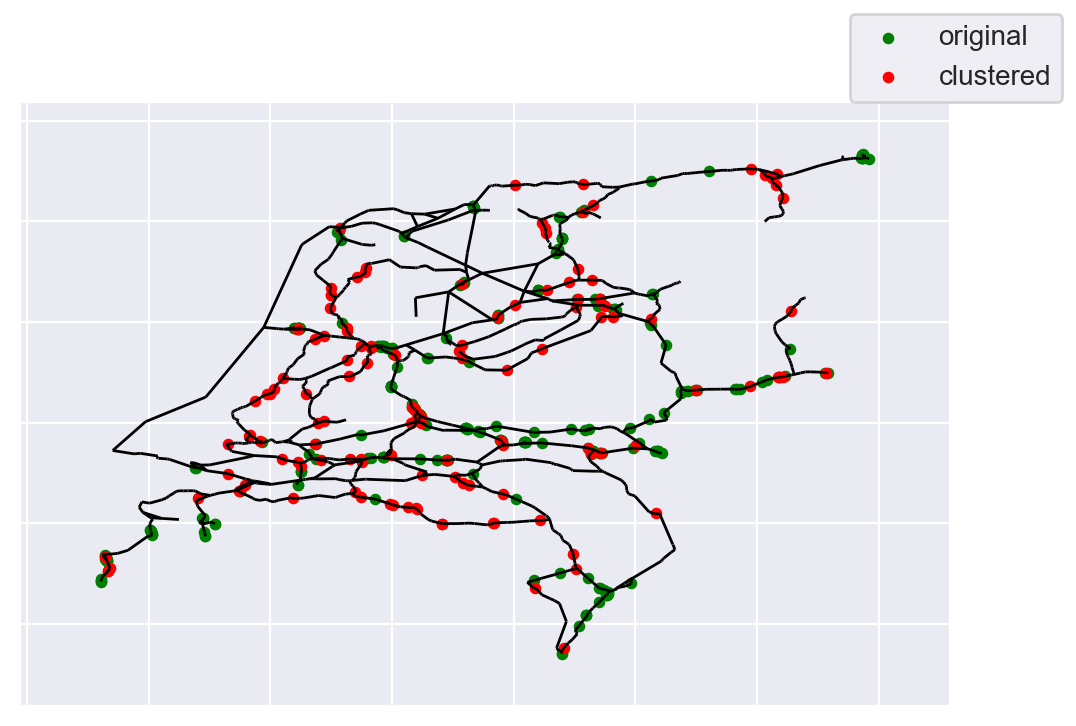

In [181]:

fig, ax = plt.subplots(1,1, dpi=200)
# plt.scatter(
#     other_nodes[:, 0], other_nodes[:, 1],
#     s=10,
#     c='green', edgecolor='white',
#     label='centroids'
# )
plt.scatter(
    all_berth_nodes[:, 0], all_berth_nodes[:, 1],
    s=10,
    c='green', edgecolor='green',
    label='original',
    alpha=1
)

plt.scatter(
    resulting_harbour_nodes[:, 0], resulting_harbour_nodes[:, 1],
    s=10,
    c='red', edgecolor='red',
    label='clustered',
    alpha = 1
)
nx.draw_networkx_edges(G, width=1, pos=pos_dict)
fig.legend()
plt.show()

## Only cluster harbour nodes?
Select node on main route afterwards to include as harbour node

In [155]:
len(all_berth_nodes)/10

27.9

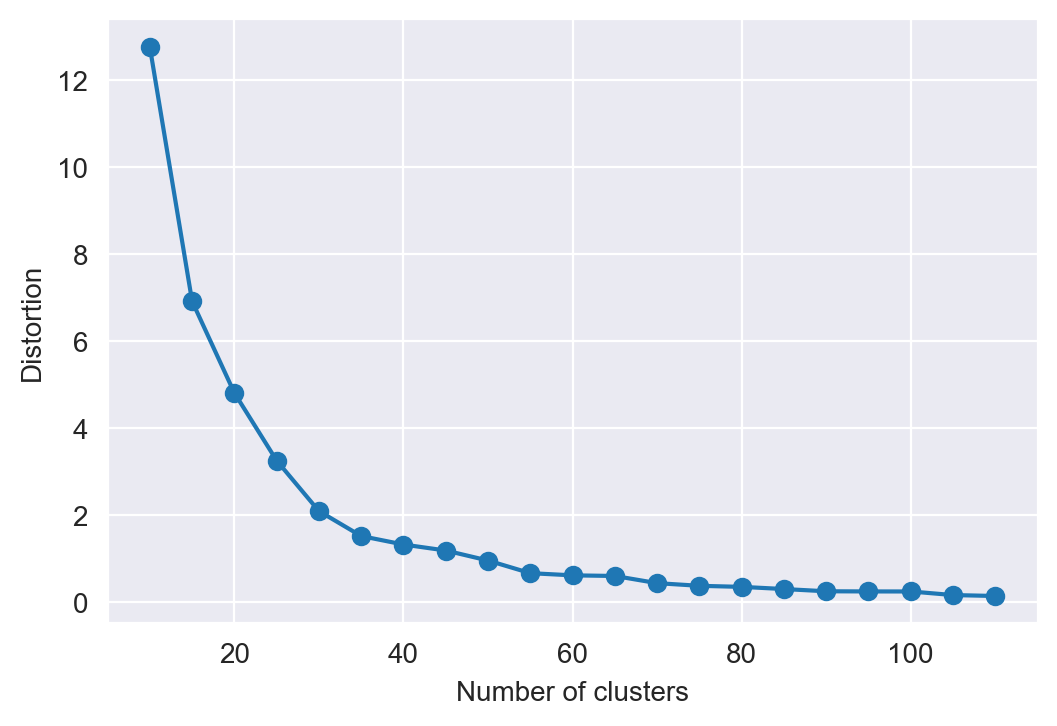

In [209]:
all_berth_nodes = df_nodes.loc[df_nodes.index.str.contains('Berth')].loc[:,['X','Y']].to_numpy()
plt.subplots(dpi=200)
distortions = []
for i in range(10, 111, 5):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(all_berth_nodes)
    distortions.append(km.inertia_)

# plot
plt.plot(range(10, 111, 5), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

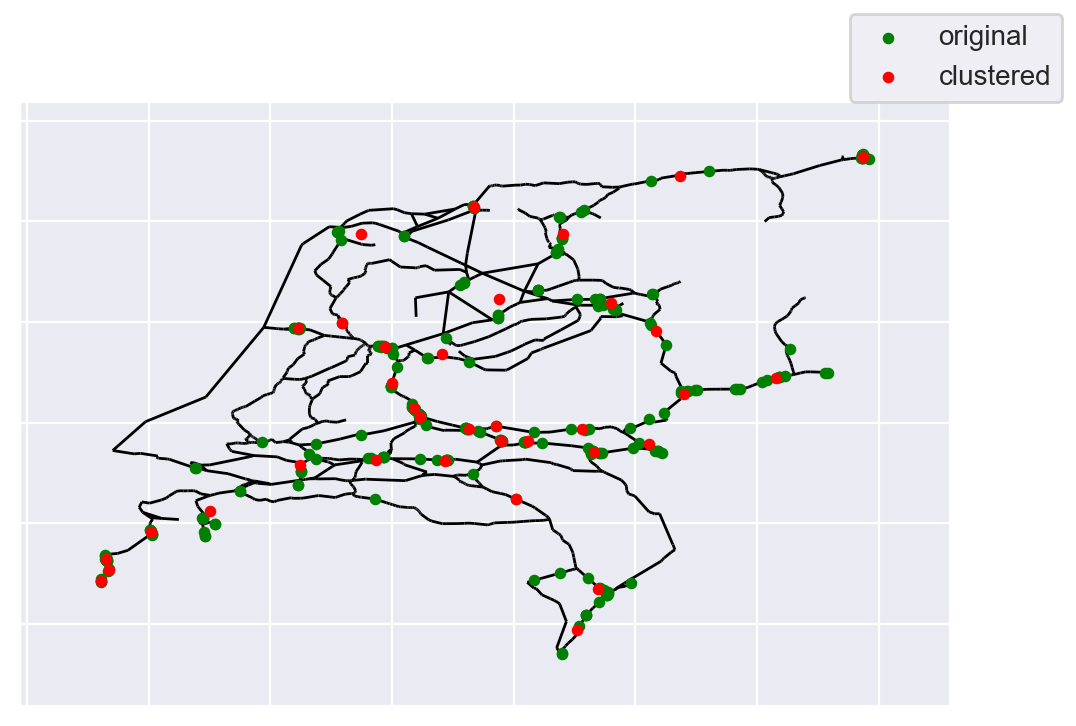

In [212]:
clusters = 35
km = KMeans(
    n_clusters=clusters, init='random',
    n_init=100, max_iter=300,
    tol=1e-04, random_state=0
)

km.fit(all_berth_nodes)

fig, ax = plt.subplots(1,1, dpi=200)
# plt.scatter(
#     other_nodes[:, 0], other_nodes[:, 1],
#     s=10,
#     c='green', edgecolor='white',
#     label='centroids'
# )
nx.draw_networkx_edges(G, width=1, pos=pos_dict)
plt.scatter(
    all_berth_nodes[:, 0], all_berth_nodes[:, 1],
    s=10,
    c='green', edgecolor='green',
    label='original',
    alpha=1
)

plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=10,
    c='red', edgecolor='red',
    label='clustered',
    alpha=1
)

fig.legend()
plt.show()

In [210]:
pickle.dump( km.cluster_centers_, open( "data/Clustering_files/clustercenters_45.p", "wb" ) )

In [7]:
# plt.subplots(dpi=200)
# # calculate distortion for a range of number of cluster
# distortions = []
# for i in range(600, 1000, 20):
#     km = KMeans(
#         n_clusters=i, init='random',
#         n_init=20, max_iter=300,
#         tol=1e-04, random_state=0
#     )
#     km.fit(arr)
#     distortions.append(km.inertia_)
#
# # plot
# plt.plot(range(600, 1000, 20), distortions, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.show()

In [ ]:

# clusters = 250
# km = KMeans(
#     n_clusters=clusters, init='random',
#     n_init=100, max_iter=300,
#     tol=1e-04, random_state=0
# )

In [ ]:
# X = df_nodes.X.to_numpy()
# Y = df_nodes.Y.to_numpy()

In [ ]:
# arr = np.vstack((X,Y)).T

In [ ]:
# y_km = km.fit_predict(arr)

In [ ]:
# y_km

In [ ]:
# fig, ax = plt.subplots(1,1, dpi=200)
# plt.scatter(
#     km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
#     s=10,
#     c='red', edgecolor='white',
#     label='centroids'
# )
#

In [ ]:
# df_nodes['cluster'] = y_km

In [ ]:
# len(df_nodes.loc[df_nodes.index.str.contains('Berth')])

In [ ]:
# harbour_clusters = list(df_nodes.loc[df_nodes.index.str.contains('Berth')].cluster.unique())

In [ ]:
# len(harbour_clusters)

In [ ]:
# df_ch = pd.DataFrame(km.cluster_centers_)

In [ ]:
# resulting_harbour_nodes = df_ch.loc[df_ch.index.isin(harbour_clusters)]

In [ ]:
# resulting_harbour_nodes = resulting_harbour_nodes.to_numpy()

In [ ]:
# fig, ax = plt.subplots(1, 2, dpi=200)
#
#
# sns.scatterplot(
#     x = resulting_harbour_nodes[:, 0], y = resulting_harbour_nodes[:, 1],
#     s=10, ax = ax[0]
# )
#
# sns.scatterplot(
#     x = berth_nodes_2[:, 0], y = berth_nodes_2[:, 1],
#     s=10, ax = ax[1]
# )

In [ ]:
# # idea: cluster nodes and then select locations to place charging stations (somewhat arbitrary). However, clustering first will make sure that these harbour nodes will be on main routes.

## Observe convergence

In [ ]:
# df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
# X = df_nodes.X.to_numpy()
# Y = df_nodes.Y.to_numpy()
# arr = np.vstack((X, Y)).T
#
# # calculate distortion for a range of number of cluster
# distortions = []
# for i in ab:
#     km = KMeans(
#         n_clusters=i, init='random',
#         n_init=20, max_iter=300,
#         tol=1e-04, random_state=0
#     )
#
#     km.fit(arr)
#     distortions.append(km.inertia_)
#

In [ ]:
# # plot
# plt.subplots(dpi=200)
# plt.plot(ab, distortions, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.show()

## Old

In [ ]:
# def graph_to_edge_matrix(G):
#     """Convert a networkx graph into an edge matrix.
#     See https://www.wikiwand.com/en/Incidence_matrix for a good explanation on edge matrices
#
#     Parameters
#     ----------
#     G : networkx graph
#     """
#     # Initialize edge matrix with zeros
#     graph_dict = dict()
#     graph_dict['nodes'] = G.nodes
#     for node in G.nodes:
#         graph_dict[node] = []
#
#     # Loop to set 0 or 1 (diagonal elements are set to 1)
#     for node_1 in graph_dict['nodes']:
#         for node_2 in graph_dict['nodes']:
#             if (node_2 in G.neighbors(node_1)) or (node_1 == node_2):
#                 graph_dict[node_1].append(1)
#             else:
#                 graph_dict[node_1].append(0)
#
#     return graph_dict

In [ ]:
# df = graph_to_edge_matrix(G)
# df = pd.DataFrame.from_dict(df)
# df.set_index('nodes', inplace=True)
# pickle.dump(df, open( "data/edge_matrix.p", "wb" ) )

In [ ]:
# edge_mat = df.to_numpy()

In [ ]:
# k_clusters = 650
# print()
# model = cluster.KMeans(n_clusters=k_clusters, n_init=10).fit(edge_mat)

In [ ]:
# results = model.labels_

In [ ]:
# results

In [ ]:
# model.cluster_centers_

In [ ]:
# # extract position for drawing purposes
# pos_dict = {}
# for node in G.nodes:
#     pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])
#
# #extract data
# df_links = nx.to_pandas_edgelist(G)
# df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [ ]:
# df_links.Code.unique()

In [ ]:
# nodes_1 = list(df_links.loc[df_links.Code != '_0'].source)+list(df_links.loc[df_links.Code != '_0'].target)
# nodes_2

In [ ]:
# H = G.subgraph(nodes)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1,2, dpi=100)
# nx.draw_networkx_edges(H, pos_dict, ax=ax1)
# nx.draw_networkx_edges(G, pos_dict, ax=ax2)